In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import random
from sklearn.metrics import r2_score

In [2]:
#Lectura de los datos de diabetes
diabetes = pd.read_csv('datasets/diabetes_normalized.dat')
target = ' C_peptide'
X_diab = diabetes.drop(columns=target) #Elimino la variable objetivo
X_diab = X_diab[X_diab.columns[1:]] #Elimino la primera variable, que solo es un ID
y_diab = diabetes[target].values #Guardo la variable objetivo
#Transformo los dataframes a vectores de numpy
X_diab = pd.DataFrame.to_numpy(X_diab)

#Lectura de los datos de láser
laser = pd.read_csv('datasets/laser_normalized.dat')
target = ' Output'
X_laser = laser.drop(columns=target) #Elimino la variable objetivo
X_laser = X_laser[X_laser.columns[1:]] #Elimino la primera variable, que solo es un ID
y_laser = laser[target].values #Guardo la variable objetivo
#Transformo los dataframes a vectores de numpy
X_laser = pd.DataFrame.to_numpy(X_laser)

#Lectura de los datos de terremotos
terremoto = pd.read_csv('datasets/quake_normalized.dat')
target = ' Richter'
X_terr = terremoto.drop(columns=target) #Elimino la variable objetivo
X_terr = X_terr[X_terr.columns[1:]] #Elimino la primera variable, que solo es un ID
y_terr = terremoto[target].values #Guardo la variable objetivo
#Transformo los dataframes a vectores de numpy
X_terr = pd.DataFrame.to_numpy(X_terr)


# CODIFICACIÓN

Represento las posibles soluciones como arrays de números con tantos valores como parámetros tenga mi problema + 1.
Es decir, los cromosomas serán vectores con los posibles pesos que puede adoptar la regresión lineal.

## FUNCIÓN DE FITNESS

In [3]:
def Fitness_MSE(poblacion,X,y):
    fitness = []
    for individuo in poblacion:
        y_pred = []
        for ejemplo in X:
            y_pred.append(individuo[0] + np.sum(ejemplo*individuo[1:]))
        fitness.append(np.round(1/mean_squared_error(y,y_pred),5)) #Divido entre 1 para invertir la salida
    return fitness

In [4]:
def Fitness_r2(poblacion,X,y):
    fitness = []
    for individuo in poblacion:
        y_pred = []
        for ejemplo in X:
            y_pred.append(individuo[0] + np.sum(ejemplo*individuo[1:]))
        r2Score = r2_score(y,y_pred)
        if(r2Score > 0):
            fitness.append(np.round(r2Score,5)*10)
        else:
            fitness.append(np.abs(np.round(1/r2Score,5))) #Divido entre 1 para invertir la salida
    return fitness

In [5]:
def Fitness_MSE_real(poblacion,X,y):
    fitness = []
    for individuo in poblacion:
        y_pred = []
        for ejemplo in X:
            y_pred.append(individuo[0] + np.sum(ejemplo*individuo[1:]))
        fitness.append(np.round(mean_squared_error(y,y_pred),5))
    return fitness

## POBLACIÓN INICIAL

In [6]:
def CrearPoblacion(X,numIndividuos= 10):
    poblacion = np.array([[random.uniform(-1, 1) for _ in range(X.shape[1]+1)] for _ in range(numIndividuos)])
    return poblacion

## SELECCIÓN DE PROGENITORES

In [7]:
def SelProgenitores_ruleta(poblacion,X,y):
    resultado_fitness = Fitness_MSE(poblacion,X,y) #Resultados de fitness de toda la población
    resultado_fitness /= np.sum(resultado_fitness) #Los normalizo para que sumen 1

    intervalos = []
    intervalos.append(0)
    for i in range(1,len(resultado_fitness)+1):
        intervalos.append(intervalos[i-1]+resultado_fitness[i-1]) #Genero los intervalos sumando los valores
    intervalos = intervalos[1:] #Elimino el cero del inicio

    progenitores_escogidos = []
    for i in range(len(poblacion)): #Seleccionaré tantos progenitores como población tenía
        numero_aleatorio = np.random.random() #Número aleatorio entre 0 y 1
        for i,intervalo in enumerate(intervalos):
            if numero_aleatorio < intervalo: #En cuanto encuentro el itervalo, meto al ejemplo correspondiente
                progenitores_escogidos.append(poblacion[i])
                break

    return progenitores_escogidos

In [8]:
def SelProgenitores_torneo(poblacion,X,y,reemplazo = False):
    progenitores_escogidos = []
    resultado_fitness = Fitness_MSE(poblacion,X,y) #Resultados de fitness de toda la población
    for _ in range(len(poblacion)): #Seleccionaré tantos progenitores como población tenía
        if(reemplazo):
            contrincante1 = random.randint(0,len(poblacion)-1)
            contrincante2 = random.randint(0,len(poblacion)-1)
            if(resultado_fitness[contrincante1] >= resultado_fitness[contrincante2]):
                progenitores_escogidos.append(poblacion[contrincante1])
            else:
                progenitores_escogidos.append(poblacion[contrincante2])
        else:
            contrincante1 = random.randint(0,len(poblacion)-1)
            contrincante2 = random.randint(0,len(poblacion)-1)
            #Obligo a que el valor del primer y el segundo contrincante sean distintos
            while contrincante2 == contrincante1:
                contrincante2 = random.randint(0,len(poblacion)-1)
            if(resultado_fitness[contrincante1] >= resultado_fitness[contrincante2]):
                progenitores_escogidos.append(poblacion[contrincante1])
            else:
                progenitores_escogidos.append(poblacion[contrincante2])

    return progenitores_escogidos

In [9]:
def SelProgenitores_elitista(poblacion,X,y,numElite=1):
    #Seleccionaré los numElite mejores individuos de la población como progenitores
    resultado_fitness = Fitness_MSE(poblacion,X,y)

    #Creo un diccionario donde guardo el índice de cada cromosoma con su fitness
    indexed_list = list(enumerate(resultado_fitness))
    #Ordeno el diccionario por el valor del fitness de mayor a menor
    mejores_ordenados = sorted(indexed_list, key=lambda x: x[1],reverse=True)
    #Almaceno los índices de los ejemplos de la población ordenados de mayor a menor
    sorted_indices = [x[0] for x in mejores_ordenados]

    numSeleccionados = len(poblacion)//numElite
    seleccionados = []
    for i in range(len(poblacion)):
        for j in range(numSeleccionados):
            seleccionados.append(poblacion[sorted_indices[i]])
            if(len(seleccionados) == len(poblacion)):
                break
        if(len(seleccionados) == len(poblacion)):
            break
    
    return seleccionados

## MÉTODO DE CRUZAMIENTO

In [10]:
def Cruzamiento_sobreUnPunto(cromosoma1_,cromosoma2_,prob_cruz):
    cromosoma1 = np.copy(cromosoma1_)
    cromosoma2 = np.copy(cromosoma2_)
    numero_aleatorio = np.random.random()
    if numero_aleatorio > prob_cruz:
        return cromosoma1,cromosoma2
    else:
        punto_corte = np.random.randint(1,len(cromosoma1)) #Genero al azar el punto de corte
        #Intercambio los valores desde el punto de corte de los cromosomas
        aux = np.copy(cromosoma1)
        cromosoma1[punto_corte:] = cromosoma2[punto_corte:]
        cromosoma2[punto_corte:] = aux[punto_corte:]
        return cromosoma1,cromosoma2

In [11]:
def Cruzamiento_simple(cromosoma1_,cromosoma2_,prob_cruz,alpha = 0.5):
    cromosoma1 = np.copy(cromosoma1_)
    cromosoma2 = np.copy(cromosoma2_)
    numero_aleatorio = np.random.random()
    if numero_aleatorio > prob_cruz:
        return cromosoma1,cromosoma2
    else:
        punto_corte = np.random.randint(1,len(cromosoma1)) #Genero al azar el punto de corte
        aux = np.copy(cromosoma1) #Copio el cromosoma 1 para no perder la referencia
        cromosoma1[punto_corte:] = alpha*cromosoma1[punto_corte:] + (1-alpha) * cromosoma2[punto_corte:]
        cromosoma2[punto_corte:] = alpha*cromosoma2[punto_corte:] + (1-alpha) * aux[punto_corte:]
        return cromosoma1,cromosoma2

In [12]:
def Cruzamiento_aritmetico_individual(cromosoma1_,cromosoma2_,prob_cruz,alpha = 0.5):
    cromosoma1 = np.copy(cromosoma1_)
    cromosoma2 = np.copy(cromosoma2_)
    numero_aleatorio = np.random.random()
    if numero_aleatorio > prob_cruz:
        return cromosoma1,cromosoma2
    else:
        punto_corte = np.random.randint(1,len(cromosoma1)) #Genero al azar el punto
        aux = np.copy(cromosoma1) #Copio el cromosoma 1 para no perder la referencia
        cromosoma1[punto_corte] = alpha*cromosoma1[punto_corte] + (1-alpha) * cromosoma2[punto_corte]
        cromosoma2[punto_corte] = alpha*cromosoma2[punto_corte] + (1-alpha) * aux[punto_corte]
        return cromosoma1,cromosoma2

In [13]:
def Cruzamiento_aritmetico_total(cromosoma1_,cromosoma2_,prob_cruz,alpha = 0.5):
    cromosoma1 = np.copy(cromosoma1_)
    cromosoma2 = np.copy(cromosoma2_)
    numero_aleatorio = np.random.random()
    if numero_aleatorio > prob_cruz:
        return cromosoma1,cromosoma2
    else:
        aux = np.copy(cromosoma1) #Copio el cromosoma 1 para no perder la referencia
        cromosoma1 = alpha*cromosoma1 + (1-alpha) * cromosoma2
        cromosoma2 = alpha*cromosoma2 + (1-alpha) * aux
        return cromosoma1,cromosoma2

## MUTACIÓN

In [14]:
def Mutacion_no_uniforme(cromosoma,prob_mut):
    for i in range(len(cromosoma)):
        #Hago que la mutación sea variar el valor del peso en el rango [-1,1]
        numero_aleatorio_mutacion = random.uniform(-1, 1)
        numero_aleatorio_prob_mutacion = np.random.random()
        if numero_aleatorio_prob_mutacion < prob_mut:
            cromosoma[i] += numero_aleatorio_mutacion
    return cromosoma

## SELECCIÓN DE SUPERVIVIENTES

In [15]:
def SelSupervivientes(poblacion,nuevos,X,y):
    supervivientes = []
    for i in range(len(poblacion)):
        supervivientes.append(poblacion[i])
    for i in range(len(nuevos)):
        supervivientes.append(nuevos[i])

    num_supervivientes = len(supervivientes)//2
    mejores_poblacion = Fitness_MSE(supervivientes,X,y)

    #Creo un diccionario donde guardo el índice de cada cromosoma con su fitness
    indexed_list = list(enumerate(mejores_poblacion))
    #Ordeno el diccionario por el valor del fitness de mayor a menor
    mejores_ordenados = sorted(indexed_list, key=lambda x: x[1],reverse=True)
    #Aquí almaceno los índices de los ejemplos de la población ordenados de mayor a menor
    sorted_indices = [x[0] for x in mejores_ordenados]

    resultado = []
    for i in range(num_supervivientes):
        resultado.append(supervivientes[sorted_indices[i]])
    return resultado

## ALGORITMO GENERAL

In [16]:
def Resultado_cromosoma(cromosoma,X,y):
    y_pred = []
    for ejemplo in X:
        y_pred.append(cromosoma[0] + np.sum(ejemplo*cromosoma[1:]))
    error = (np.round(mean_squared_error(y,y_pred),5)) 
    print('Error cuadrático medio del cromosoma {} de {}'.format(cromosoma,error))

In [17]:
def Algoritmo_general(X,y,prob_cruz = 0.95,prob_mut = 0.01,num_iteraciones = 2000,numIndividuos = 10,reemplazo = False,alpha = 0.5,numElite = 1):

    poblacion = CrearPoblacion(X,numIndividuos)


    supervivientes = poblacion

    for _ in range(num_iteraciones):
    #Reinicio la población a los supervivientes anteriores
        poblacion = supervivientes.copy()

    ## Seleccion de progenitores
    progenitores = SelProgenitores_torneo(poblacion,X,y,reemplazo)
    #progenitores = SelProgenitores_ruleta(poblacion,X,y)
    #progenitores = SelProgenitores_elitista(poblacion,X,y,numElite)

    ## Cruzamiento
    nuevos = []
    for i in range(0,len(progenitores),2):
      #nuevo1,nuevo2 = Cruzamiento_sobreUnPunto(progenitores[i],progenitores[i+1],prob_cruz)
      #nuevo1,nuevo2 = Cruzamiento_simple(progenitores[i],progenitores[i+1],prob_cruz,alpha)
      nuevo1,nuevo2 = Cruzamiento_aritmetico_individual(progenitores[i],progenitores[i+1],prob_cruz,alpha)
      #nuevo1,nuevo2 = Cruzamiento_aritmetico_total(progenitores[i],progenitores[i+1],prob_cruz,alpha)
      nuevos.append(nuevo1)
      nuevos.append(nuevo2)

    ## Mutacion
    for i in range(len(nuevos)):
      nuevos[i] = Mutacion_no_uniforme(nuevos[i],prob_mut)

    ## Seleccion de supervivientes
    supervivientes = SelSupervivientes(poblacion,nuevos,X,y)


    fitness_final = Fitness_MSE(supervivientes,X,y)
    mejor_cromosoma = supervivientes[np.argmax(fitness_final)]

    Resultado_cromosoma(mejor_cromosoma,X,y)
    return mejor_cromosoma


In [18]:
def Algoritmo_general_comparaCosas(X,y,prob_cruz = 0.95,prob_mut = 0.01,num_iteraciones = 10,numIndividuos = 10,reemplazo = True,numElite = 1):


  fig, ax = plt.subplots()

  fitness_generales = []
  numeros_individuos = np.arange(6,52,2)

  fitness_generales = []
  for num_ind in numeros_individuos:
    poblacion = CrearPoblacion(X,num_ind)
    supervivientes = poblacion
    for _ in range(num_iteraciones):
        #Reinicio la población a los supervivientes anteriores
        poblacion = supervivientes.copy()

        ## Seleccion de progenitores
        progenitores = SelProgenitores_torneo(poblacion,X,y,reemplazo)
        #progenitores = SelProgenitores_ruleta(poblacion,X,y)
        #progenitores = SelProgenitores_elitista(poblacion,X,y,numElite)

        ## Cruzamiento
        nuevos = []
        for i in range(0,len(progenitores),2):
            #nuevo1,nuevo2 = Cruzamiento_sobreUnPunto(progenitores[i],progenitores[i+1],prob_cruz)
            #nuevo1,nuevo2 = cruzamiento(progenitores[i],progenitores[i+1],prob_cruz,0.9)
            nuevo1,nuevo2 = Cruzamiento_aritmetico_individual(progenitores[i],progenitores[i+1],0.85,0.9)
            #nuevo1,nuevo2 = Cruzamiento_aritmetico_total(progenitores[i],progenitores[i+1],prob_cruz,alpha))
            nuevos.append(nuevo1)
            nuevos.append(nuevo2)

        ## Mutacion
        for i in range(len(nuevos)):
            nuevos[i] = Mutacion_no_uniforme(nuevos[i],prob_mut)

        ## Seleccion de supervivientes
        supervivientes = SelSupervivientes(poblacion,nuevos,X,y)

      


  
    #print(fitness_generales)
    fitness_final = Fitness_MSE(supervivientes,X,y)
    fitness_generales.append(np.mean(Fitness_MSE_real(supervivientes,X,y)))
  
  ax.plot(numeros_individuos,fitness_generales,)
  #ax.legend(loc=2) # upper left corner
  ax.set_xlabel("Número de cromosomas")
  ax.set_ylabel("MSE")
  mejor_cromosoma = supervivientes[np.argmax(fitness_final)]

  Resultado_cromosoma(mejor_cromosoma,X,y)
  return mejor_cromosoma


In [19]:
def Resultados_LinearRegression(X,y):
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X,y)
    y_pred = regr.predict(X)
    error = np.round(mean_squared_error(y,y_pred))
    print('Los pesos calculados por al regresión lineal son: {}'.format(regr.coef_))
    print('Con un error cuadrático medio de {}'.format(error))

In [20]:
def mostrarGrafica(X,y,mejor_cromosoma,X_label = '',Y_label = '',Z_label = ''):
    # Crea 10 puntos para la primera dimensión (B0) entre 0 y 1 (rango de la variable)
    puntos = np.linspace(0,1,10)
    # Crea 7 puntos para la segunda dimensión (B1) entre 0 y 1 (rango de la variable)
    puntos2 = np.linspace(0,1,7)

    # Crear todas las combinaciones de los puntos creados anteriormente usando meshgrid (guardar en xx, yy)
    xx, yy = np.meshgrid(puntos,puntos2)

    # Crea una matriz Xtest que contenga todos los valores de xx en la primera columna y los de yy en la segunda
    Xtest = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))

    # Utiliza predict para obtener los valores de Z (el plano) - luego hacemos un reshape (al shape de xx) para pintarlo
    regr = LinearRegression()
    regr.fit(X,y)
    Z = regr.predict(Xtest)
    Z = Z.reshape(xx.shape)

    #Calculo la predicción con los pesos del cromosoma obtenido por el genético
    regr.coef_ = mejor_cromosoma[1:]
    Z2 = regr.predict(Xtest)
    Z2 = Z2.reshape(xx.shape)

    # Pintamos las dos gráficas
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Utiliza scatter para pintar los puntos y luego plot_surface para pintar el plano de scikit-learn
    ax1.scatter(X[:,0], X[:,1], y.ravel(),c='r')
    ax1.plot_surface(xx,yy,Z,alpha=0.3)
    ax1.set_title('Plano obtenido por scikit-learn')

    # Nombra los ejes
    ax1.set_xlabel(X_label) 
    ax1.set_ylabel(Y_label) 
    ax1.set_zlabel(Z_label)

    # Utiliza scatter para pintar los puntos y luego plot_surface para pintar el plano de scikit-learn
    ax2.scatter(X[:,0], X[:,1], y.ravel(),c='r')
    ax2.plot_surface(xx,yy,Z2,alpha=0.3)
    ax2.set_title('Plano obtenido por algoritmo genético')

    # Nombra los ejes
    ax2.set_xlabel(X_label) 
    ax2.set_ylabel(Y_label) 
    ax2.set_zlabel(Z_label)

Iteración 1
Error cuadrático medio del cromosoma [ 0.42135436 -0.44168849  0.36238887] de 0.06321
Iteración 2
Error cuadrático medio del cromosoma [-0.29313889  0.36585505  0.72790817] de 0.0386
Iteración 3
Error cuadrático medio del cromosoma [-0.43296973  0.64433094  0.85473062] de 0.06098
Iteración 4
Error cuadrático medio del cromosoma [-0.50171937  0.62153042  0.82084099] de 0.05607
Iteración 5
Error cuadrático medio del cromosoma [0.20003558 0.07286111 0.14383436] de 0.05045
Calculo el cromosoma medio de los anteriores con pesos: [-0.12128761  0.2525778   0.5819406 ]
Error cuadrático medio del cromosoma [-0.12128761  0.2525778   0.5819406 ] de 0.03057
Los pesos calculados por al regresión lineal son: [0.2707814  0.32580974]
Con un error cuadrático medio de 0.0


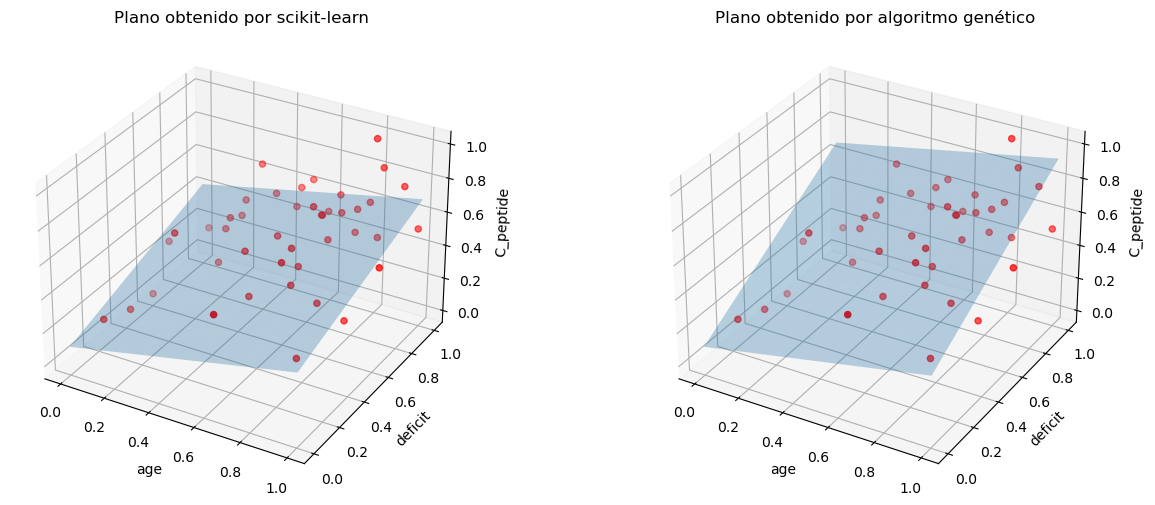

In [21]:
X = X_diab
y = y_diab

mejores_cromosomas = []
for i in range(5): #Lanzo varias veces el genético para ver los resultados generales
    print('Iteración {}'.format(i+1))
    mejor_cromosoma = Algoritmo_general(X,y,reemplazo=True,prob_cruz=0.87,numIndividuos=20,alpha=0.9,num_iteraciones=2000)
    mejores_cromosomas.append(mejor_cromosoma)

mejor_cromosoma = np.mean(mejores_cromosomas,axis = 0)
print('Calculo el cromosoma medio de los anteriores con pesos: {}'.format(mejor_cromosoma))
Resultado_cromosoma(mejor_cromosoma,X,y)
Resultados_LinearRegression(X,y)
#Llamar solo si los datos tienen dos atributos
mostrarGrafica(X,y,mejor_cromosoma,'age','deficit','C_peptide')

In [22]:
Algoritmo_general(X,y,reemplazo=True,prob_cruz=0.95,numIndividuos=20,alpha=0.9,num_iteraciones=2000)

Error cuadrático medio del cromosoma [-0.09478079  0.15965794  0.64652785] de 0.03122


array([-0.09478079,  0.15965794,  0.64652785])